# CHAPTER 09. 추천 시스템

## 01. 추천 시스템의 개요와 배경
### 추천 시스템의 개요
- 하나의 콘텐츠를 선택했을 때 선택된 콘텐츠와 연관된 추천 콘텐츠가 얼마나 사용자의 관심을 끌고 개인에게 맞춘 콘텐츠를 추천했는지는 그 사이트의 평판을 좌우하는 매우 중요한 요소
- 추천 시스템의 진정한 묘미는 사용자 자신도 좋아하는지 몰랐던 취향을 시스템이 발견하고 그에 맞는 콘텐츠를 추천해주는 것이다. 
- 이러한 추천 시스템을 접한 사용자는 해당 사이트를 더 강하게 신뢰하게 되어 더 많은 추천 콘텐츠를 선택하게 되고, 더 많은 데이터가 추천 시스템에 축적되면서 추천이 더욱 정확해지고 다양한 결과를 얻을 수 있는 좋은 선순환 시스템을 구축할 수 있게 된다.

### 온라인 스토어의 필수 요소, 추천 시스템
한정된 시간이라는 제약을 가진 상황에서 너무 많은 상품과 콘텐츠는 오히려 사용자가 어떤 상품을 골라야 할지에 대한 압박감을 느끼게 만들 수 밖에 없는데, 추천 시스템이 이러한 상황을 타개해준다. 좋은 추천 시스템은 사용자가 무엇을 원하는지 빠르게 찾아내 사용자의 온라인 쇼핑의 즐거움을 배가한다.

### 추천 시스템의 유형
- 콘텐츠 기반 필터링(Content based filtering)


- 협업 필터링(Collaborative Filtering)
    - 최근접 이웃(Nearest Neighbor) 협업 필터링
    - 잠재 요인(Latent Factor) 협업 필터링
    
    
요즘 대부분은 잠재 요인 협업 필터링 기반의 추천 시스템을 적용하고 있다. 하지만 서비스하는 아이템의 특성에 따라 콘텐츠 기반 필터링이나 최근접 이웃 기반 협업 필터링 방식을 유지하는 사이트도 많다. 또한 요즘에는 개인화 특성을 좀 더 강화하기 위해 하이브리드 형식으로 콘텐츠 기반과 협업 기반을 적절히 결합해 사용하는 경우도 늘고 있다.

## 02. 콘텐츠 기반 필터링 추천 시스템
: 사용자가 특정한 아이템을 매우 선호하는 경우, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템을 추천하는 방식
- 예) 사용자가 특정 영화에 높은 평점을 줬다면 그 영화의 장르, 출연 배우, 감독, 영화 키워드 등의 콘텐츠와 유사한 다른 영화를 추천해주는 방식

## 05. 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트

### 장르 속성을 이용한 영화 콘텐츠 기반 필터링
" 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것이다. 이렇게 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감동, 배우, 평점 등)를 기반으로 하는 방식이 바로 콘텐츠 기반 필터링이다.
- 장르 칼럼 값의 유사도를 비교한 뒤 그중 높은 평점을 가지는 영화를 추천하는 방식이다.

### 데이터 로딩 및 가공

In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

movies = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporatio...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United ...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


4803개의 레코드와 20개의 피처로 구성. 영화 제목, 예산, 장르, 등 영화에 대한 다양한 메타 정보를 가짐

In [13]:
# 콘텐츠기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 dataframe 만들기

movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count',
                    'popularity', 'keywords', 'overview']]

In [14]:
# 리스트 내부에 여러개의 딕셔너리가 있는 형태의 문자열인 두 칼럼 확인

pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


genres 칼럼은 여러 개의 개별 장르 데이터를 가지고 있고, 개별 장르의 명칭은 딕셔너리의 키인 'name'으로 추출할 수 있다. keywords 칼럼 역시 마찬가지 구조를 가지고 있다.

In [15]:
# 두 칼럼의 문자열 분해하여 개별 장르를 리스트 객체로 추출

from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

이제 두 칼럼은 문자열이 아닌 실제 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가진다.
- **ast 모듈의 literal_eval()** : 문자열이 의미하는 list[dict1, dict2]객체로 만든다.

In [16]:
# 장르명만 리스트 객체로 추출

movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### 장르 콘텐츠 유사도 측정
1. 문자열로 변환된 genres칼럼을 Count 기반으로 피처 벡터화 변환
2. genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교. 이를 위해 데이터 세트의 레코드별로 타 레코드 장르에서 코사인 유사도 값을 가지는 객체 생성
3. 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화 추천

#### 1) genres 칼럼을 문자열로 변환한 뒤, CountVectorizer를 이용해 피처 벡터 행렬로 만들기

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
print(movies_df['genres_literal'])

0       Action Adventure Fantasy Science Fiction
1                       Adventure Fantasy Action
2                         Action Adventure Crime
3                    Action Crime Drama Thriller
4               Action Adventure Science Fiction
                          ...                   
4798                       Action Crime Thriller
4799                              Comedy Romance
4800               Comedy Drama Romance TV Movie
4801                                            
4802                                 Documentary
Name: genres_literal, Length: 4803, dtype: object


In [18]:
count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


#### 2) 코사인 유사도 계산
- **cosine_similarity()** : 기준 행과 비교 행의 코사인 유사도를 행렬 형태로 반환

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


genre_sim 객체는 movies_df의 genre_literal 칼럼을 피처 벡터화한 행렬 데이터의 행별 유사도 정보를 가지고 있으며, 결국은 Movies_df DataFrame의 행별 장르 유사도 값을 가지고 있다.

#### 3) 장르 유사도가 높은 순으로 레코드 추출
genre_sim 객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값 추출

In [20]:
# 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값 얻기
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
# 0번 레코드의 비교 행 위치 인덱스 값 샘플로 추출
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


0번 레코드의 경우, 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고 그다음 813레코드이며 가장 유사도가 낮은 레코드는 2401번 레코드라는 뜻이다.

### 장르 콘텐츠 필터링을 이용한 영화 추천

In [21]:
# 장르 유사도에 따라 영화를 추천하는 함수 생성

def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
    title_movie = df[df['title'] == title_name]
    
    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # 추출된 top_n index 출력. top_n index는 2차원 데이터임
    # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]

In [24]:
# '대부'와 장르별로 유사한 영화 10개 추천
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


'대부 2편'이 가장 먼저 추천됐다. 'Goodfellas'도 대부와 비슷한 유형으로 추천되었다. 하지만 'Light Sleeper', 'Mi America', 'Kids' 등 낯선 영화도 많다. 대부를 좋아하는 고객에게 섣불리 추천하기에는 이해하기 어려운 영화이다. 개선이 필요해 보인다.

#### 좀 더 많은 후보군을 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경

In [25]:
# vote_average는 1명, 2명의 소수의 관객이 특정 영화에 매우 높은 평점을 부여해 왜곡된 데이터를 가지고 있다. 이를 확인
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


평가 횟수가 매우 작은 영화들이 있다. 이와 같은 왜곡된 평점 데이터를 회피할 수 있도록 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요하다.

IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용한다.
### 가중 평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * C
- 변수의 의미
    - **v** : 개별 영화에 평점을 투표한 횟수
    - **m** : 평점을 부여하기 위한 최소 투표 횟수(투표 횟수에 따른 가중치를 직접 조절하는 역할)
        - m값을 높이면 평점 투표 횟수가 많은 영화에 더 많은 가중 평점을 부여한다.
    - **R** : 개별 영화에 대한 평균 평점
    - **C** : 전체 영화에 대한 평균 평점

In [26]:
# C값 구하기
C = movies_df['vote_average'].mean()
# m값 구하기 
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [29]:
# 기존 평점을 새로운 가중 평점으로 변경하는 함수 생성
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( ( v/(v+m)) * R) + ((m/(m+v)) * C)

# 새로운 평점 정보 칼럼
movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [30]:
# wieghted_vote 평점이 높은 순으로 상위 10개의 영화 추출
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote',
                                                                               ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [34]:
# 새롭게 정의된 평점 기준에 따라 영화 추천

def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    # 기준 영화 인덱스는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


이전에 추천된 영화보다 훨씬 나은 영화가 추천됐다.

## 03. 최근접 이웃 협업 필터링
: 친구들에게 물어보는 것과 유사한 방식으로, 사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동 양식(User Behavior)만을 기반으로 추천을 수행
- 협업 필터링의 주요 목표 
    - : 사용자-아이템 평점 매트릭스와 같은 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 예측 평가 하는 것.
    
    
- 종류
    1. 최근접 이웃 방식(메모리 협업 필터링) 2. 잠재 요인 방식
        - 두 방식 모두 사용자-아이템 평점 행렬 데이터에만 의지해 추천을 수행한다.
        - 행은 개별사용자, 열은 개별 아이템, 값은 평점으로 구성
        - 많은 아이템을 열로 가지는 다차원 행렬이며, 희소 행렬의 특성을 가지고 있다.

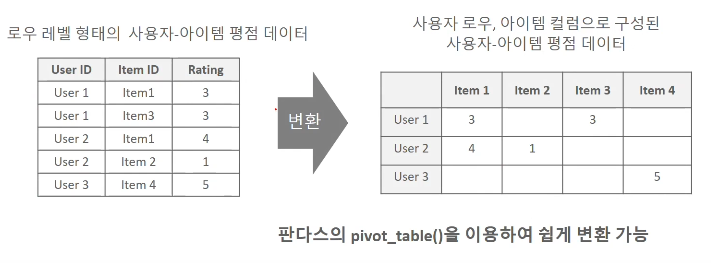

#### 최근접 이웃 협업 필터링 - 사용자 기반(User-User) 필터링
: "당신과 비슷한 고객들이 다음 상품도 구매했습니다." 


특정 사용자와 유사한 다른 사용자를 TOP-N으로 선정해 이 Top-N 사용자가 좋아하는 아이템을 추천하는 방식. 즉, 특정 사용자와 타 사용자 간의 유사도를 측정한 뒤 가장 유사도가 높은 TOP-N 사용자를 추출해 그들이 선호하는 아이템을 추천하는 것

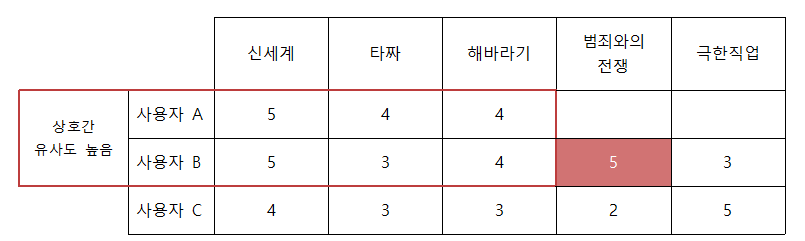

#### 최근접 이웃 협업 필터링 - 아이템 기반(Item-Item) 필터링
: "이 상품을 선택한 다른 고객들은 다음 상품도 구매했습니다." 


아이템이 가지는 속성과는 상관없이 사용자들이 그 아이템을 좋아하는지/싫어하는지의 평가 척도가 유사한 아이템을 추천하는 기준이 되는 알고리즘

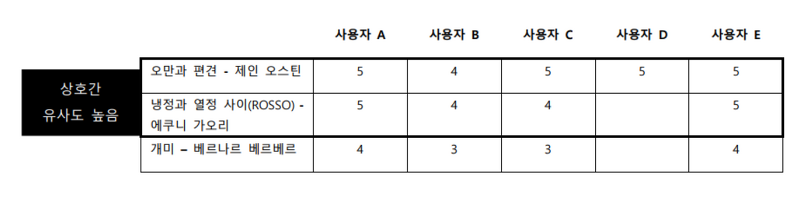

- 일반적으로 사용자 기반보다는 **아이템 기반 협엽 필터링이 정확도가 더 높다** 왜냐하면 비슷한 영화를 좋아한다고 해서 사람들의 취향이 비슷하다고 판단하기는 어려운 경우가 많기 때문이다. 따라서 최근접 이웃 협업 필터링은 대부분 아이템 기반의 알고리즘을 적용한다.


- 다차원 희소행렬이라는 특징이 있으므로 **유사도 측정을 위해 주로 코사인 유사도를 이용**한다.

## 06. 아이템 기반 최근접 이웃 협업 필터링 실습
사용자가 영화의 평점을 매긴 사용자-영화 평점 행렬 데이터 세트

### 데이터 가공 및 변환

In [37]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/ml-latest-small/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [39]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


영화에 대한 메타 정보인 title과 genres를 가지고 있는 영화 정보이다.

In [40]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


사용자별로 영화에 대한 평점을 매긴 데이터 세트이다.

In [41]:
# ratings.csv의 ratings를 이용해 아이템 기반 최근접 이웃 협업 필터링 구현
# 먼저 모든 사용자를 로우로, 모든 영화를 칼럼으로 구성한 데이터 세트로 변경

ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 NaN값이 할당되었다. 이를 0으로 변환시켜주어야 한다.(최소 평점이 0.5)

In [44]:
# title 칼럼을 얻기 위해 movies와 조인
ratings_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행(가독성 높이기 위함)
ratings_matrix = ratings_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화간 유사도 산출
**코사인 유사도**를 기반으로하고 사이킷런의 **cosine_similarity()**를 이용해 측정


cosine_similarity() 함수는 행을 기준으로 서로 다른 행을 비교해 유사도를 산출한다. 이를 바로 적용하면 영화간 유사도가 아닌 사용자 간의 유사도가 만들어지다(userId가 기준인 행 레벨 데이터이므로)

In [45]:
# 행과 열의 위치 변경

ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- **transpose()** : 전치 행렬 변경

In [46]:
# 변경한 데이터 세트를 기반으로 영화의 코사인 유사도 구하기 

from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)

print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [47]:
# '대부'와 유사도가 높은 상위 6개 영화 추출

item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

'대부 2', 'Goodfellas(좋은 친구들)'이 각각 첫번째 두번째로 유사도가 높게 나타났다.


이 둘을 제외하고 앞의 **콘텐츠 기반 필터링과 다른 점은** 'One Flew Over the Cuckoo's Nest(뻐꾸기 둥지 위로 날아간 새)', 'Star Wars: Episode IV' 와 같이 **장르가 완전히 다른 영화도 유사도가 매우 높게 나타났다는 것**이다.

In [49]:
# '인셉션'과 유사도가 높은 상위 6개 영화 추출(자신제외)

item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

'다크나이트'가 가장 유사도가 높다. 그 뒤를 이어서 주로 스릴러와 액션이 가미된 좋은 영화가 높은 유사도를 나타내고 있다. 

### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천
앞의 아이템 기반의 영화 유사도 데이터는 개인적인 취향을 반영하지 않고 영화 간의 유사도만을 가지고 추천한 것이다. 따라서 영화 유사도 데이터를 이용해 최근접 이웃 협업 필터링으로 개인에게 최적화된 영화 추천을 구현해보자

개인화된 영화 추천의 가장 큰 특징은 **개인이 아직 관람하지 않은 영화를 추천**한다는 것이다.
- 아직 관람하지 않은 영화에 대해 아이템 유사도와 기존 관람한 영화의 평점 데이터를 기반으로 해 새롭게 모든 영화의 예측 평점을 계산한 후 높은 평점을 가진 영화를 추천하는 방식
### $ Ȓ_{u,i} = \sum^N (S_{𝑖,N} * R_{𝑢,N}) / \sum^N (|S_{𝑖,N}|) $
    - $ Ȓ_{u,i} $ : 사용자 u, 아이템 i의 개인화된 예측 평점 값
    - $ S_{𝑖,N} $ : 아이템 i와 가장 유사도가 높은 Top-N개 아이템의 유사도 벡터
    - $ R_{𝑢,N} $ : 사용자 u의 아이템 i와 가장 유사도가 높은 Top-N개 아이템에 대한 실제 평점 벡터
    - 여기서의 N값은 아이템의 최근접 이웃 범위 계수를 의미한다. 이는 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템을 추출하는데 사용된다.

In [61]:
# 영화 간의 유사도를 가지는 item_sim_df와 사용자-영화 평점 데이터프레임인 ratings_matrix 변수를 활용해
# 사용자별로 최적화된 평점 스코어 예측하는 함수

# 인자로 사용자-영화 평점 넘파이 행렬과 영화 간의 유사도를 가지는 넘파이 행렬을 입력받는다
def predict_rating(ratings_arr, item_sim_arr):
    ratings_pred = ratings_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [62]:
# 개인화된 예측 평점 구하기

ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
                              
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, 
                                   columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기 때문에 기존 영화를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 많이 발생한다. 예측 평점이 실제 평점보다 작을 수 있다. 이는 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문이다.

In [63]:
# 위의 예측 결과가 원래 실제 평점과의 오차 확인하기(기존에 평점이 부여된 데이터 대상)

from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함
def get_mse(pred, actual):
    # 평점이 있는 실제 영화만 추출
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


- flatten() : 다차원 배열을 1차원 배열로 만든다.

In [66]:
# 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수로 변경
# predict_rating()함수와 유사하지만 N인자를 가지고 있어 Top-N 유사도를 가지는 영화 유사도 벡터만 예측값을 계산하는데 적용

def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)
    
    # 사용자-아이템 평점 행렬의 열 크기만큰 루프 수행
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]) :
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))
            
    return pred

In [67]:
# predict_rating_topsim()함수 이용하여 예측 평점 계산하고 실제 평점과의 MSE 구하기
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 TOP-20 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, 
                                   columns=ratings_matrix.columns)

아이템 기반 최근접 TOP-20 이웃 MSE: 3.695009387428144


기존의 9.89보다 많이 향상됐다.

In [68]:
# 특정 사용자에 대해 영화 추천(userId=9)
# 먼저 9번이 어떤 영화를 좋아하는지 확인
user_rating_id = ratings_matrix.loc[9, :]
# 9번이 평점 준 영화 중, 높은 순으로 나열
user_rating_id[user_rating_id>0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

대작 영화나 어드벤처 영화, 코미디 영화 등 전반적으로 흥행성이 좋은 영화에 높은 평점을 주고 있다.

In [69]:
# 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록, 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수

def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함
    # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임
    user_rating = ratings_matrix.loc[userId, :]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦
    already_seen = user_rating[user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듦
    movies_list = ratings_matrix.columns.tolist()
    
    # list compregension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
    unseen_list = [movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list

In [73]:
# 최종적으로 사용자에게 영화를 추천하는 함수 만들기
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
    # 가장 예측 평점이 높은 순으로 정렬함
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, 
                             columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591
